# Problem Statement

# Executive Summary

# Imports

Import libraries and set default settings

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import numpy as np
# import talib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA

from pytrends.request import TrendReq
from pytrends import dailydata

plt.style.use('tableau-colorblind10')
sns.set_style("darkgrid")
sns.set_context("talk")

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

Pull Google Trends data

In [ ]:
btc_goog = dailydata.get_daily_data('bitcoin', 2009, 1, 2021, 3, geo='')
btc_goog.drop(columns=['bitcoin_monthly', 'isPartial', 'scale', 'bitcoin'], inplace=True)
btc_goog.to_csv('../data/btc_goog.csv', index_label='Date')

Import BTC on-chain dataset (https://coinmetrics.io/community-network-data/)

In [2]:
btc = pd.read_csv('../data/btc_onchain.csv')

In [3]:
btc_goog['Date'] = pd.to_datetime(btc_goog['Date'])
btc_goog.set_index('Date', inplace=True)
btc_goog.sort_index(inplace=True)

Change `Date` to datetime format, feature `Year` and `Month` columns

In [4]:
btc['Date'] = pd.to_datetime(btc['date'])
btc['Year'] = btc['Date'].dt.year
btc['Month'] = btc['Date'].dt.month

In [5]:
btc_goog.head()

,bitcoin_unscaled
Date,
2009-02-01,0
2009-02-02,0
2009-02-03,0
2009-02-04,0
2009-02-05,0


In [6]:
btc.head()

,date,AdrActCnt,AssetEODCompletionTime,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Date,Year,Month
0,2009-01-03,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-03,2009,1
1,2009-01-04,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-04,2009,1
2,2009-01-05,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-05,2009,1
3,2009-01-06,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-06,2009,1
4,2009-01-07,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-07,2009,1


Set `Date` as index

In [7]:
btc.set_index('Date', inplace=True)
btc.sort_index(inplace=True)

In [8]:
btc_goog.head()

,bitcoin_unscaled
Date,
2009-02-01,0
2009-02-02,0
2009-02-03,0
2009-02-04,0
2009-02-05,0


In [9]:
btc = btc.join(btc_goog, how='left')

In [84]:
btc2

,date,AdrActCnt,AssetEODCompletionTime,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Date,Year,Month,bitcoin_unscaled
0,2009-01-03,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-03,2009.0,1.0,NaN
1,2009-01-04,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-04,2009.0,1.0,NaN
2,2009-01-05,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-05,2009.0,1.0,NaN
3,2009-01-06,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-06,2009.0,1.0,NaN
4,2009-01-07,0.0,1.614335e+09,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,2009-01-07,2009.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,61.0
2021-03-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,60.0
2021-03-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,64.0
2021-03-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,67.0


In [10]:
btc.rename(columns={'bitcoin_unscaled': 'Goog_Trend'}, inplace=True)

# Bitcoin On-chain Metrics

Check data types

In [11]:
btc.dtypes

date                       object
AdrActCnt                 float64
AssetEODCompletionTime    float64
BlkCnt                    float64
BlkSizeByte               float64
BlkSizeMeanByte           float64
CapMVRVCur                float64
CapMrktCurUSD             float64
CapRealUSD                float64
DiffMean                  float64
FeeMeanNtv                float64
FeeMeanUSD                float64
FeeMedNtv                 float64
FeeMedUSD                 float64
FeeTotNtv                 float64
FeeTotUSD                 float64
HashRate                  float64
IssContNtv                float64
IssContPctAnn             float64
IssContUSD                float64
IssTotNtv                 float64
IssTotUSD                 float64
NVTAdj                    float64
NVTAdj90                  float64
PriceBTC                    int64
PriceUSD                  float64
ROI1yr                    float64
ROI30d                    float64
SplyCur                   float64
SplyExpFut10yr

Check standard descriptions for dataset

In [12]:
btc.describe()

,AdrActCnt,AssetEODCompletionTime,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,NVTAdj,NVTAdj90,PriceBTC,PriceUSD,ROI1yr,ROI30d,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d,Year,Month,Goog_Trend
count,4.483000e+03,4.483000e+03,4483.000000,4.483000e+03,4.477000e+03,3922.000000,3.922000e+03,4.483000e+03,4.477000e+03,4225.000000,3922.000000,4225.000000,3922.000000,4483.000000,3.922000e+03,4.477000e+03,4477.000000,4477.000000,3.922000e+03,4477.000000,3.922000e+03,4.223000e+03,3833.000000,4484.0,3923.000000,3558.000000,3893.000000,4.483000e+03,4.477000e+03,4.483000e+03,4483.000000,4.483000e+03,4.483000e+03,3.922000e+03,4225.000000,3922.000000,4.225000e+03,3.922000e+03,4.483000e+03,3.922000e+03,3743.000000,3893.000000,3863.000000,4484.000000,4484.000000,4106.000000
mean,3.648221e+05,1.614357e+09,151.456168,7.562404e+07,5.074830e+05,2.072175,7.422908e+10,3.270644e+10,3.070059e+12,0.000904,1.582875,0.000408,0.830767,54.478171,4.774669e+05,2.238619e+07,4172.675620,78.946674,6.168512e+06,4172.675620,6.168512e+06,3.467260e+04,63.497971,1.0,4174.403612,791.326891,20.225829,1.217344e+07,1.943544e+07,1.058770e+07,141157.076957,3.445798e+05,2.478348e+05,1.125273e+09,92.559260,4706.791631,5.332417e+01,4.201381e+01,1.035319e+06,3.187841e+09,0.048304,0.043848,0.045762,2014.652765,6.427297,58.651242
std,3.550083e+05,2.332511e+05,34.863417,6.844086e+07,4.637088e+05,2.971956,1.552496e+11,5.475677e+10,5.767401e+12,0.007641,4.540864,0.005767,2.523944,99.321111,1.472195e+06,4.203225e+07,2861.810407,834.948740,9.190318e+06,2861.810407,9.190318e+06,1.549004e+06,33.272432,0.0,8430.239704,2336.080110,65.050760,5.645276e+06,1.014174e+06,4.372467e+06,127820.353640,3.136177e+05,1.749008e+05,2.181175e+09,668.964886,6654.725031,6.321021e+02,5.609347e+01,1.894152e+06,5.834451e+09,0.021081,0.029234,0.026395,3.547591,3.471091,25.563089
min,0.000000e+00,1.614335e+09,0.000000,0.000000e+00,2.150000e+02,0.386829,1.776705e+05,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.988411e-07,200.000000,1.169460,3.070000e+02,200.000000,3.070000e+02,3.717399e+00,11.810125,1.0,0.050541,-83.730494,-61.668266,0.000000e+00,1.707025e+07,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.647065e+02,0.010000,0.762873,1.000000e-08,8.203471e-08,0.000000e+00,5.874592e+02,0.020298,0.007481,0.010406,2009.000000,1.000000,0.000000
25%,1.881450e+04,1.614336e+09,138.000000,3.505538e+06,2.332627e+04,1.261066,7.647299e+08,4.362272e+07,1.583178e+06,0.000141,0.033384,0.000017,0.021654,9.079868,2.361020e+03,1.145994e+01,1887.500000,4.083325,3.110184e+05,1887.500000,3.110184e+05,3.837790e+01,41.349958,1.0,69.064612,22.707528,-9.338708,8.218867e+06,1.875429e+07,8.216255e+06,7612.500000,1.798350e+04,1.318012e+05,1.751767e+07,1.341251,552.198973,1.105211e-02,3.741887e+00,3.642119e+05,6.116484e+07,0.032594,0.025111,0.027875,2012.000000,3.000000,44.000000
50%,2.476460e+05,1.614337e+09,151.000000,5.470911e+07,3.756871e+05,1.702003,7.471600e+09,4.204159e+09,4.668438e+10,0.000241,0.121166,0.000100,0.061372,23.458165,1.447033e+04,3.229962e+05,3675.000000,9.931633,1.695374e+06,3675.000000,1.695374e+06,5.815095e+01,54.407268,1.0,573.263192,150.946913,5.215237,1.386839e+07,1.978366e+07,1.263928e+07,96199.000000,2.644960e+05,2.348947e+05,1.708114e+08,3.380388,1836.822138,2.680072e-02,1.622938e+01,6.670714e+05,6.753281e+08,0.042205,0.035667,0.038558,2015.000000,6.000000,63.000000
75%,6.606265e+05,1.614337e+09,165.000000,1.401612e+08,9.576345e+05,2.380780,1.122490e+11,7.738720e+10,3.462542e+12,0.000663,0.903953,0.000224,0.350676,53.815762,2.413188e+05,2.556413e+07,5850.000000,31.842911,9.952140e+06,5850.000000,9.952140e+06,8.379053e+01,78.912695,1.0,6497.856280,

Take a look at correlations to Bitcoin price in descending order, sorted for top 20.

In [13]:
abs(btc.corr()['PriceUSD']).sort_values(ascending=False).head(30)

PriceUSD                  1.000000
CapMrktCurUSD             0.999567
TxTfrValAdjUSD            0.936071
IssContUSD                0.928368
IssTotUSD                 0.928368
CapRealUSD                0.924623
TxTfrValUSD               0.837653
TxTfrValMeanUSD           0.797082
HashRate                  0.782732
DiffMean                  0.779701
TxTfrValMedUSD            0.720620
FeeMeanUSD                0.709528
FeeTotUSD                 0.688411
AdrActCnt                 0.677222
FeeMedUSD                 0.650389
Year                      0.623848
TxTfrCnt                  0.601427
AssetEODCompletionTime    0.597908
BlkSizeMeanByte           0.597559
BlkSizeByte               0.596589
TxCnt                     0.523817
SplyExpFut10yrCMBI        0.498482
SplyCur                   0.491897
IssContNtv                0.451649
IssTotNtv                 0.451649
SplyFF                    0.403806
IssContPctAnn             0.310947
NVTAdj90                  0.296294
FeeTotNtv           

There are a number of features above that aren't useful to use as they are intuitively directly correlated with Bitcoin price (example market capitalization, value of new issuance). We'll select some below to take a deeper look in the later section of this notebook.

Check for null values in `PriceUSD`

In [14]:
btc['PriceUSD'].isnull().sum()

561

In [15]:
btc[['PriceUSD']][btc['PriceUSD'].isnull()]

,PriceUSD
Date,
2009-01-03,NaN
2009-01-04,NaN
2009-01-05,NaN
2009-01-06,NaN
2009-01-07,NaN
...,...
2010-07-13,NaN
2010-07-14,NaN
2010-07-15,NaN


Looks like null values range from 2009 to 2010, we'll drop out null values

In [16]:
btc = btc.dropna(axis=0, subset=['PriceUSD'])

Check for other null values

In [17]:
btc.isnull().sum().sort_values(ascending=False)

ROI1yr                    365
VtyDayRet180d             180
NVTAdj90                   90
VtyDayRet60d               60
ROI30d                     30
VtyDayRet30d               30
Goog_Trend                 13
TxTfrValNtv                 1
TxTfrValMedUSD              1
IssContNtv                  1
HashRate                    1
FeeTotUSD                   1
FeeTotNtv                   1
FeeMedUSD                   1
FeeMedNtv                   1
FeeMeanUSD                  1
FeeMeanNtv                  1
DiffMean                    1
CapRealUSD                  1
CapMrktCurUSD               1
CapMVRVCur                  1
BlkSizeMeanByte             1
BlkSizeByte                 1
BlkCnt                      1
AssetEODCompletionTime      1
AdrActCnt                   1
IssContPctAnn               1
IssContUSD                  1
IssTotNtv                   1
SplyFF                      1
TxTfrValMedNtv              1
TxTfrValMeanUSD             1
TxTfrValMeanNtv             1
TxTfrValAd

Drop nulls

In [18]:
btc = btc.drop(columns=[
    'ROI1yr',
    'VtyDayRet180d',
    'NVTAdj90',
    'VtyDayRet60d',
    'VtyDayRet30d',
    'ROI30d'
])

In [19]:
btc['Goog_Trend_Diff1'] = btc['Goog_Trend'].diff()

In [20]:
btc.dropna(inplace=True)

Rename `PriceUSD` column to `Close`

In [21]:
btc.rename(columns={'PriceUSD': 'Close'}, inplace=True)

# Features

## `Close`

Plot the `Close` price over the years to look at the trend

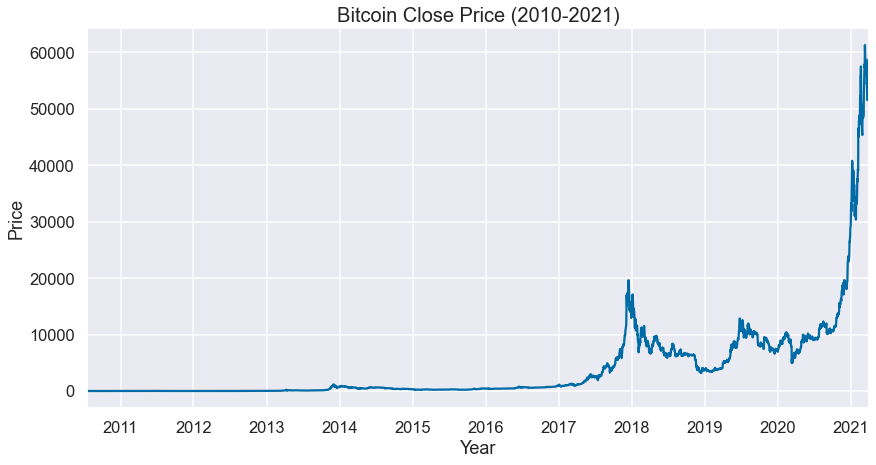

In [22]:
plt.figure(figsize=(14,7))
btc['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2010-2021)', size=20);

We observe that there's distinct volatility happening from 2017 onwards. However, the volatilities prior to this period could be masked due to the exponential growth in price. We take a look at different windows of time periods to investigate further

1. 2017-2021
2. 2010-2016
3. 2010-2013

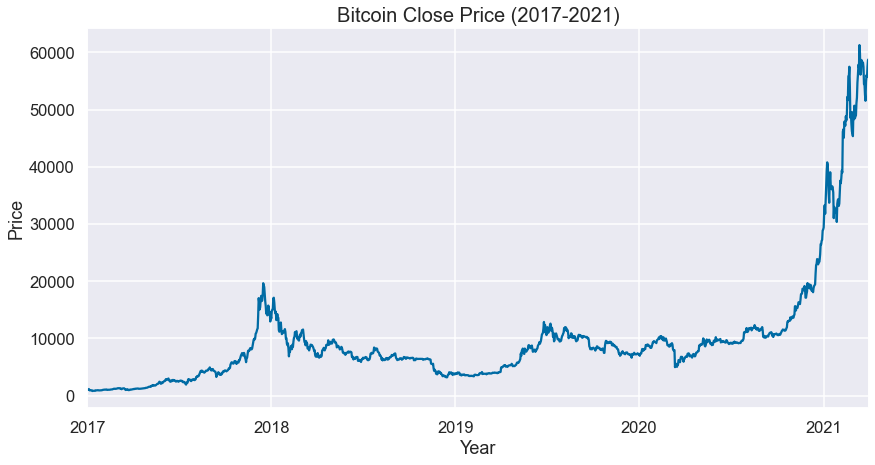

In [23]:
btc2 = btc[btc['Year'] > 2016]
plt.figure(figsize=(14,7))
btc2['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2017-2021)', size=20);

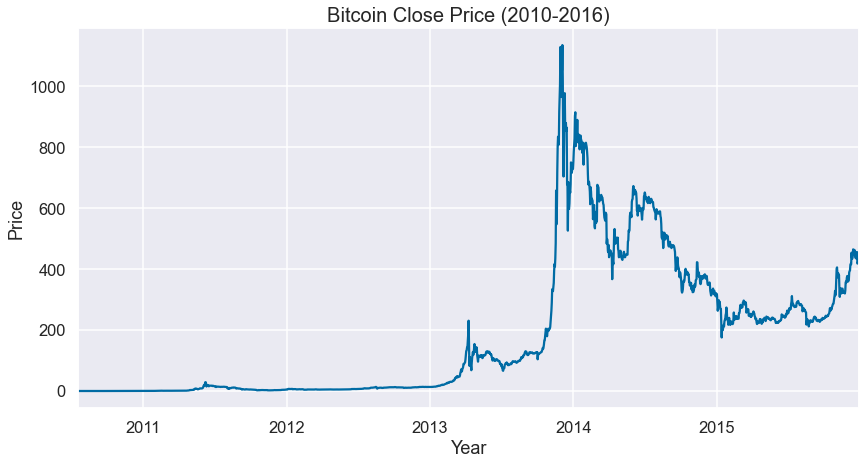

In [24]:
btc3 = btc[btc['Year'] < 2016]
plt.figure(figsize=(14,7))
btc3['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2010-2016)', size=20);

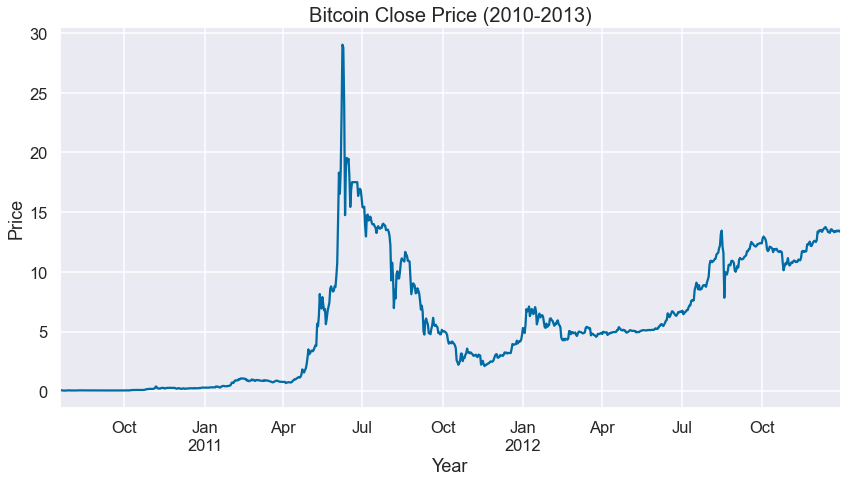

In [25]:
btc4 = btc[btc['Year'] < 2013]
plt.figure(figsize=(14,7))
btc4['Close'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Close Price (2010-2013)', size=20);

We can see that on the full timeframe, the volatilities that happen in the earlier years have been masked due to the exponential increment in absolute price of Bitcoin. It does not make sense to use `Close` as the main parameter for our models. We'll explore taking the logarithmic `Close` to see how it trends over the years.
  
We can check for stationarity using the Augmented Dickey-Fuller test.

Define a function to print out test statistic and p-value from Augmented Dickey-Fuller test.

In [26]:
def dfuller(df):
    print('Test Statistic: ' + str(adfuller(df)[0]))
    print('p-value: ' + str(adfuller(df)[1]))

Augmented Dickey-Fuller test on `Close`

In [27]:
dfuller(btc['Close'])

Test Statistic: 7.112075785410034
p-value: 1.0


For large p-values, we have don't have enough evidence to reject the null hypothesis that our time series is not stationary.

## `LogClose`

Per above, we want to take the Logarithmic `Close` to see if we can see any smoothing effect on the `Close` price.

Create `LogClose` column

In [28]:
btc['LogClose'] = np.log(btc['Close'])

Plot `LogClose` over time

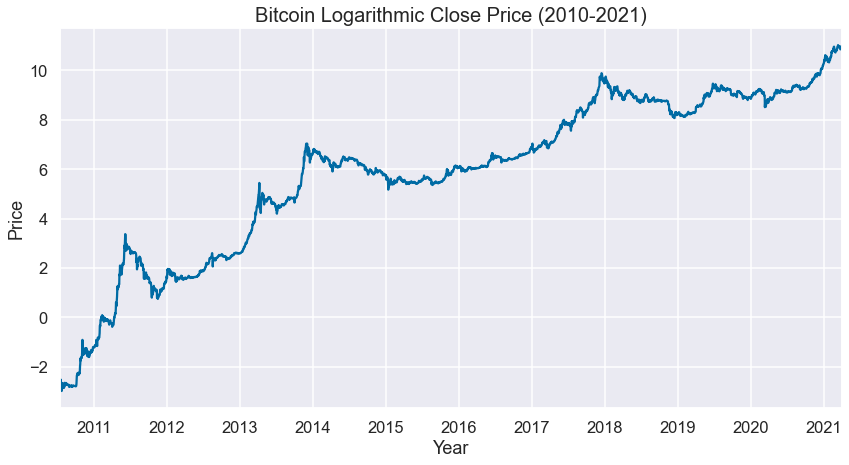

In [29]:
plt.figure(figsize=(14,7))
btc['LogClose'].plot()
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Bitcoin Logarithmic Close Price (2010-2021)', size=20);

Run the Augmented Dickey-Fuller test on `LogClose`

In [30]:
dfuller(btc['LogClose'])

Test Statistic: -2.3363331936393075
p-value: 0.1605173434429315


Again, we observe that p-value is not small enough to reject our null hypothesis and that we still have a non-stationary dataset. We'll explore using returns or differences `Close` price instead.

## `Returns`

Create a `Returns` column based on previous day's `Close` price

In [31]:
btc['Returns'] = btc['Close'].pct_change()

In [32]:
btc.head()

,date,AdrActCnt,AssetEODCompletionTime,BlkCnt,BlkSizeByte,BlkSizeMeanByte,CapMVRVCur,CapMrktCurUSD,CapRealUSD,DiffMean,FeeMeanNtv,FeeMeanUSD,FeeMedNtv,FeeMedUSD,FeeTotNtv,FeeTotUSD,HashRate,IssContNtv,IssContPctAnn,IssContUSD,IssTotNtv,IssTotUSD,NVTAdj,PriceBTC,Close,SplyCur,SplyExpFut10yrCMBI,SplyFF,TxCnt,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,TxTfrValNtv,TxTfrValUSD,Year,Month,Goog_Trend,Goog_Trend_Diff1,LogClose,Returns
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-07-19,2010-07-19,929.0,1.614335e+09,174.0,139254.0,800.310345,62.565130,279285.200000,4463.911468,181.543289,0.000150,0.000012,0.0,0.0,0.05,0.004040,0.001570,8700.0,91.870389,702.960000,8700.0,702.960000,85.889156,1,0.080800,3456500.0,17934137.5,3456500.0,334.0,512.0,40243.73,3251.693384,86.951152,7.025653,2.625,0.212100,44518.99,3597.134392,2010,7,13.0,-4.0,-2.515778,NaN
2010-07-20,2010-07-20,936.0,1.614335e+09,181.0,197425.0,1090.745856,45.106630,259000.404990,5741.958660,181.543289,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.001633,9050.0,95.316761,676.358346,9050.0,676.358346,215.744281,1,0.074736,3465550.0,17936400.0,3465550.0,423.0,738.0,16063.23,1200.497201,42.528835,3.178423,1.375,0.102762,31386.28,2345.676511,2010,7,13.0,0.0,-2.593797,-0.075053
2010-07-21,2010-07-21,784.0,1.614335e+09,207.0,124991.0,603.821256,38.357560,275266.471297,7176.328942,181.543289,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.001868,10350.0,108.684082,819.646128,10350.0,819.646128,166.836660,1,0.079193,3475900.0,17938987.5,3475900.0,247.0,377.0,20834.15,1649.915979,71.822334,5.687816,18.500,1.465068,27077.02,2144.306726,2010,7,0.0,-13.0,-2.535869,0.059639
2010-07-22,2010-07-22,594.0,1.614335e+09,176.0,100750.0,572.443182,25.132348,203749.573975,8107.064743,181.543289,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.001588,8800.0,92.174362,514.533891,8800.0,514.533891,105.440311,1,0.058470,3484700.0,17941187.5,3484700.0,221.0,344.0,33049.03,1932.368865,112.714622,6.590397,1.010,0.059054,38773.83,2267.096549,2010,7,39.0,39.0,-2.839246,-0.261679
2010-07-23,2010-07-23,655.0,1.614335e+09,194.0,103001.0,530.932990,23.190988,211735.723764,9130.086543,181.543289,0.000045,0.000003,0.0,0.0,0.01,0.000606,0.001751,9700.0,101.319254,587.750836,9700.0,587.750836,181.444798,1,0.060593,3494400.0,17943612.5,3494400.0,220.0,335.0,19258.75,1166.942929,63.158149,3.826934,5.000,0.302964,21157.98,1282.022725,2010,7,0.0,-39.0,-2.803578,0.036311


Since first row has no differencing reference, it returns null value for `Returns`. We'll drop this row.

In [33]:
btc.dropna(inplace=True)

Run Augmented Dickey-Fuller test

In [34]:
dfuller(btc['Returns'])

Test Statistic: -10.028542785749483
p-value: 1.6077489465363234e-17


p-value is very small and we're able to reject the hypothesis and accept the null hypothesis that our data is now stationary.
  
Let's plot the `Returns` over time.

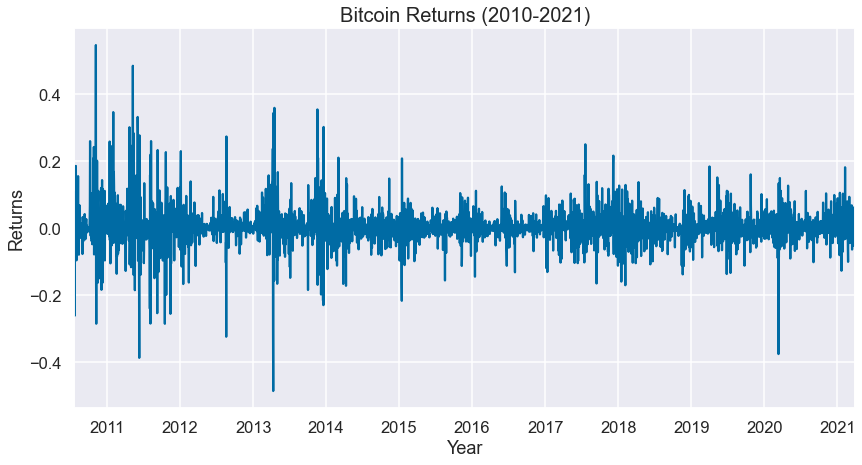

In [35]:
btc['Returns'].plot(figsize=(14,7))
plt.xlabel('Year')
plt.ylabel('Returns')
plt.title('Bitcoin Returns (2010-2021)', size=20);

We can observe that dataset has a mean of 0 which is a good sign of stationarity.

## `Close_Diff1`

As an alternative, we also take the difference on each day's `Close` price as well. This will also be useful for ARIMA time-series.
  
Create `Close_Diff1` column

In [36]:
btc['Close_Diff1'] = btc['Close'].diff()

Create `LogClose_Diff1` column

In [37]:
btc['LogClose_Diff1'] = btc['LogClose'].diff()
btc.dropna(inplace=True)

Plot `Close_Diff1` over time

Text(0.5, 1.0, 'Differenced Close Price Over Time')

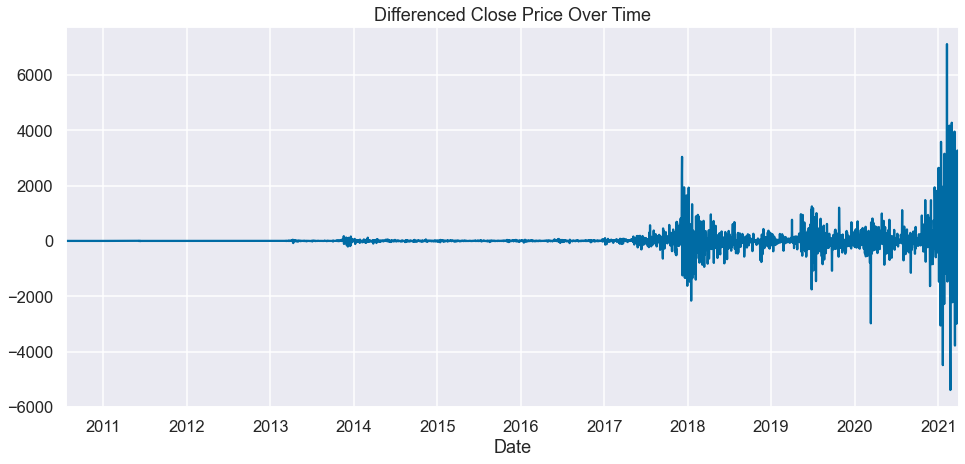

In [38]:
btc['Close_Diff1'].plot(figsize=(16,7))
plt.title('Differenced Close Price Over Time')

If we compare above plot to the previous plot for `Returns` over time, it's interesting to observe that the differenced plot exhibits bigger changes from 2017. This is expected due to the exponential growth over time of Bitcoin, especially from 2017 as observed in the `Close` price chart. As price increases, the absolute change increases as well. We also observe a mean 0, meaning the dataset is stationary.

Plot `LogClose_Diff1` over time

Text(0.5, 1.0, 'Differenced Log Close Price Over Time')

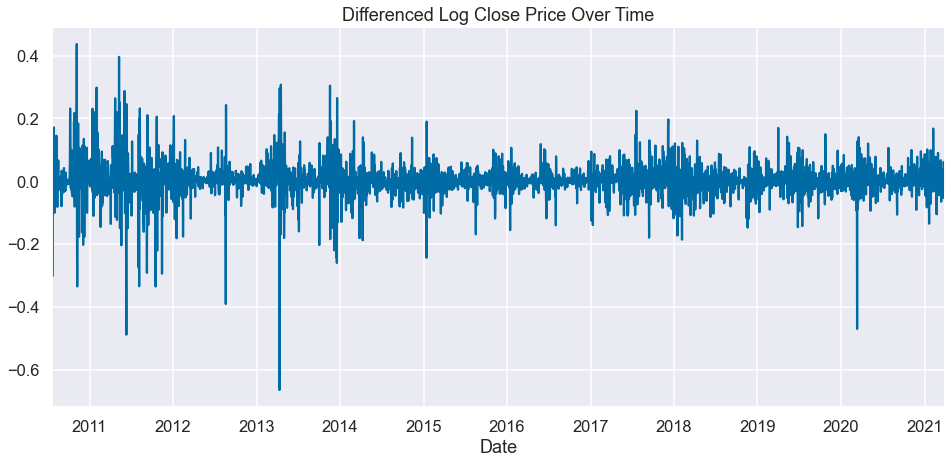

In [39]:
btc['LogClose_Diff1'].plot(figsize=(16,7))
plt.title('Differenced Log Close Price Over Time')

We can see that the `LogClose_Diff1` plot is fairly similar to `Returns` plot, but seem to assign a more balanced distribution across the time period. The fluctuations for `Returns` is significantly larger in the early years. Using the `LogClose_Diff1` seem to smoothen this a little more.

Run Augmented Dickey-Fuller test

In [40]:
dfuller(btc['Close_Diff1'])

Test Statistic: -10.17399623075539
p-value: 6.969595314902631e-18


In [41]:
dfuller(btc['LogClose_Diff1'])

Test Statistic: -10.462444362909677
p-value: 1.3481226757964752e-18


Both p-values are very small and we're able to reject the hypothesis and accept the null hypothesis that both data points are stationary.

## `Target`

We also want to create buy/sell targets. If next day's return is positive, it means that we want to make a buy order today. We use this intuition to create our `Target` column. We also create a `Target_shifted` column as we also want to feed tomorrow's price target into our non Neural Network classifier at a later stage. 
  
*If you're confused now, Keras' TimeSeriesGenerator will default to taking next day's target as output whereas non Neural Network classifiers like RandomForestClassifier will not do so.*

In [42]:
btc['Target_shifted'] = np.where(btc['Returns'].shift(-1) > 0, 1, 0)
btc['Target'] = np.where(btc['Returns'] > 0, 1, 0)

btc.dropna(inplace=True)

## `AdrActCnt`

`AdrActCnt` is the count of unique addresses that were active in the network in the previous day. Theoretically speaking, we can expect that if there's higher counts of active unique addresses, it implicitly means higher volume and more holders of Bitcoin.

Create a function to easily plot two features

In [43]:
def compare_plot(df1, df2, label1, label2, plot_title):
    fig, ax = plt.subplots(1, 1, figsize=(14,7))
    ax.plot(df1, 'salmon', label=label1)
    ax2 = ax.twinx()
    ax2.plot(df2, 'lightslategrey', label=label2)
    plt.draw()
    plt.title(plot_title, size=20)
    ax.legend()
    ax2.legend(loc=1);

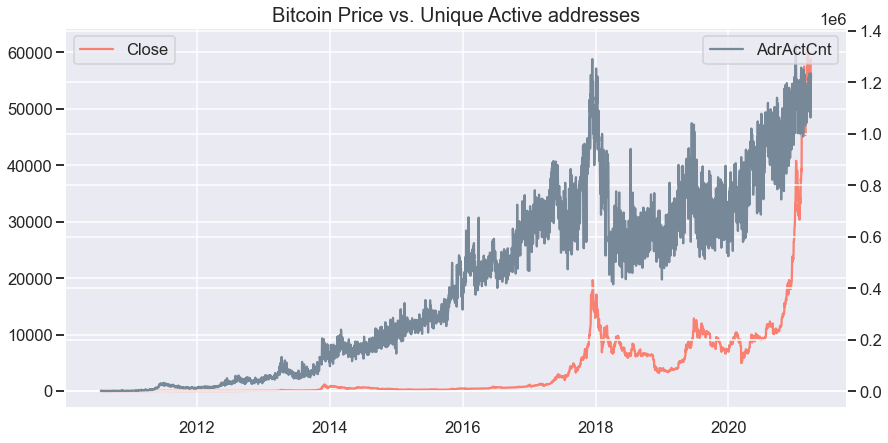

In [44]:
compare_plot(btc['Close'], 
             btc['AdrActCnt'], 
             'Close', 
             'AdrActCnt', 
             'Bitcoin Price vs. Unique Active addresses')

Above we can see a positive relationship. The 2018 spike follows closely as well. 
  
Couple of observations above:
1. Spike in 2018 Bitcoin price and unique addresses moved in tendem with each other
2. Growth in unique addresses through 2010-2016 did not reflect the same growth in Bitcoin price
  
Let's also take the Logarithmic `AdrActCnt` as well.

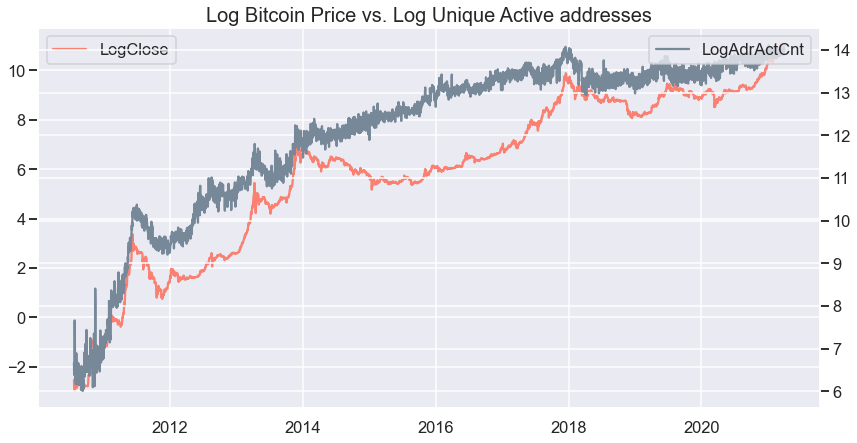

In [45]:
btc['LogAdrActCnt'] = np.log(btc['AdrActCnt'])

compare_plot(btc['LogClose'], 
             btc['LogAdrActCnt'], 
             'LogClose', 
             'LogAdrActCnt', 
             'Log Bitcoin Price vs. Log Unique Active addresses')

We see that their relationship is very similar (in the general sense). This is interesting as it explains the network effect that Bitcoin has that's likely contributing to the exponential growth in price.

## `Hashrate`

Hash rate is the speed at which miners are able to perform proof-of-work calculations (to mine a Bitcoin, miners have to solve a proof-of-work problem). The higher the hash rate, the more blocks are being mined which increases the chance an individual miner has to solve the block reward puzzle and receive newly mined Bitcoin. Typically, a high hash rate is an indication of a healthy bitcoin mining environment. It reflects in some sense that miners are willing to improve their mining infrastructure to be more effective in mining, hence an implicit sign that they are anticipating a rise of Bitcoin's price.

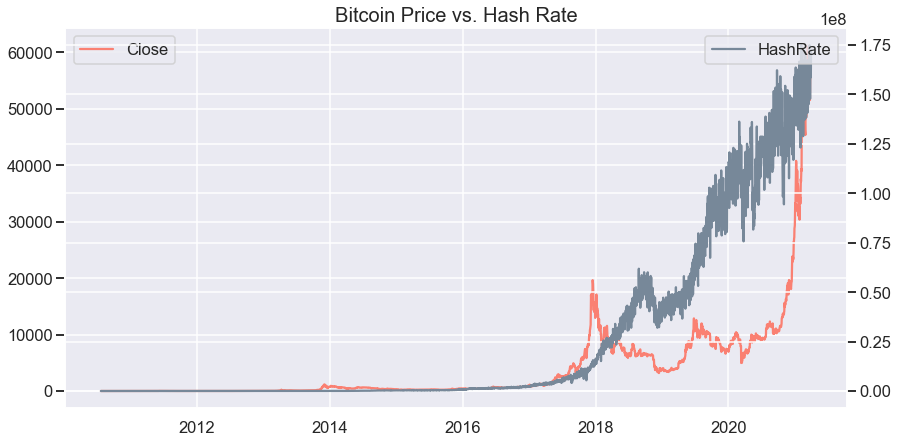

In [46]:
compare_plot(btc['Close'], 
             btc['HashRate'], 
             'Close', 
             'HashRate', 
             'Bitcoin Price vs. Hash Rate')

We plot `LogHashRate` and `LogClose` to observe their relationship

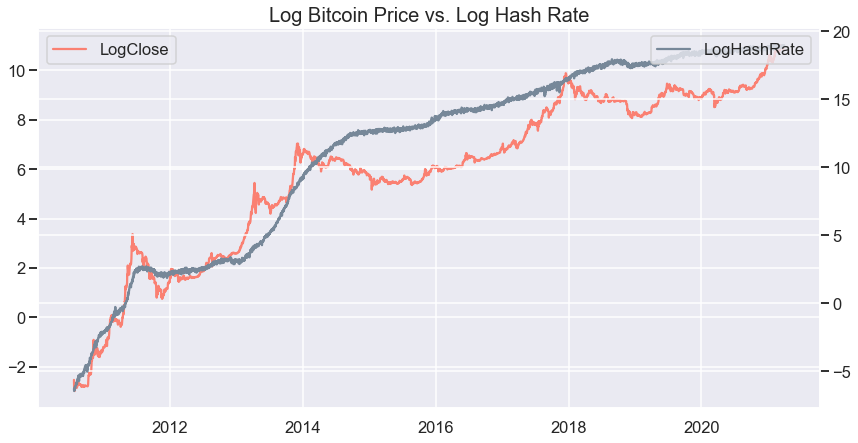

In [47]:
btc['LogHashRate'] = np.log(btc['HashRate'])

compare_plot(btc['LogClose'], 
             btc['LogHashRate'], 
             'LogClose', 
             'LogHashRate', 
             'Log Bitcoin Price vs. Log Hash Rate')

Again, we see very similar trends between the logarithmics of `Close` and `HashRate`.

## `TxCnt`

Transaction count is the sum count of transactions that interval.

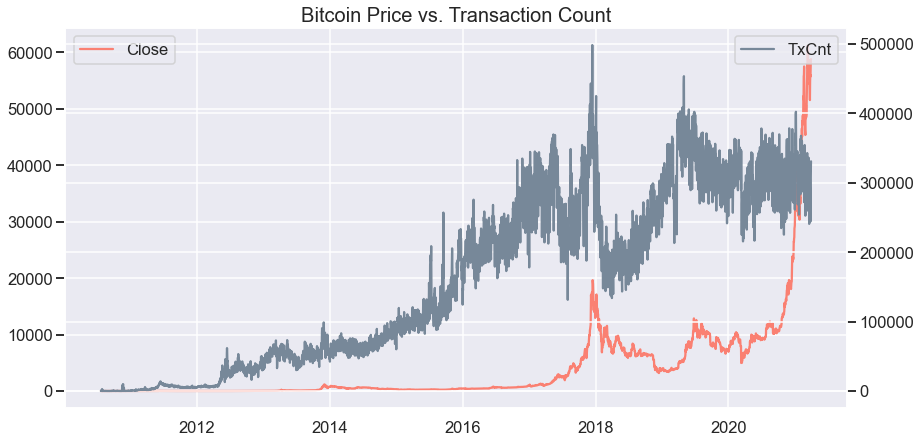

In [48]:
compare_plot(btc['Close'], 
             btc['TxCnt'], 
             'Close', 
             'TxCnt', 
             'Bitcoin Price vs. Transaction Count')

We plot `LogTxCnt` and `LogClose` to observe their relationship

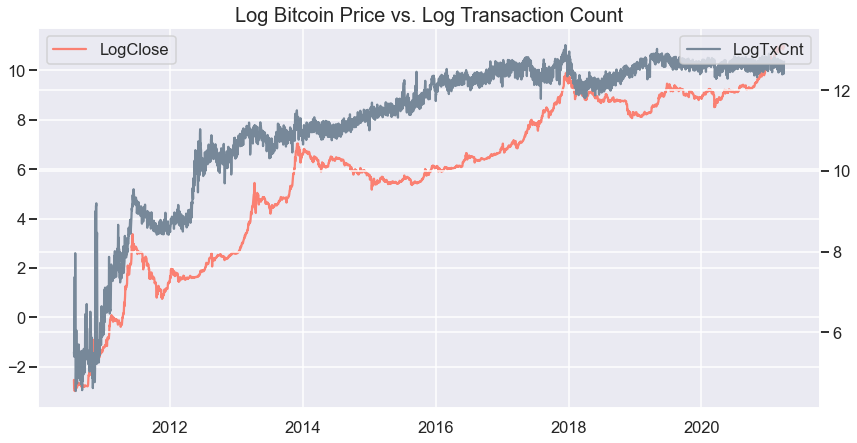

In [49]:
btc['LogTxCnt'] = np.log(btc['TxCnt'])

compare_plot(btc['LogClose'], 
             btc['LogTxCnt'], 
             'LogClose', 
             'LogTxCnt', 
             'Log Bitcoin Price vs. Log Transaction Count')

# Export

In [51]:
btc.columns

Index(['date', 'AdrActCnt', 'AssetEODCompletionTime', 'BlkCnt', 'BlkSizeByte',
       'BlkSizeMeanByte', 'CapMVRVCur', 'CapMrktCurUSD', 'CapRealUSD',
       'DiffMean', 'FeeMeanNtv', 'FeeMeanUSD', 'FeeMedNtv', 'FeeMedUSD',
       'FeeTotNtv', 'FeeTotUSD', 'HashRate', 'IssContNtv', 'IssContPctAnn',
       'IssContUSD', 'IssTotNtv', 'IssTotUSD', 'NVTAdj', 'PriceBTC', 'Close',
       'SplyCur', 'SplyExpFut10yrCMBI', 'SplyFF', 'TxCnt', 'TxTfrCnt',
       'TxTfrValAdjNtv', 'TxTfrValAdjUSD', 'TxTfrValMeanNtv',
       'TxTfrValMeanUSD', 'TxTfrValMedNtv', 'TxTfrValMedUSD', 'TxTfrValNtv',
       'TxTfrValUSD', 'Year', 'Month', 'Goog_Trend', 'Goog_Trend_Diff1',
       'LogClose', 'Returns', 'Close_Diff1', 'LogClose_Diff1',
       'Target_shifted', 'Target', 'LogAdrActCnt', 'LogHashRate', 'LogTxCnt'],
      dtype='object')

In [52]:
cols_to_keep = [
    'Close',
    'Close_Diff1',
    'LogClose',
    'LogClose_Diff1',
    'Returns',
    'Target',
    'Target_shifted',
    'Year', 
    'HashRate', 
    'LogHashRate',
    'AdrActCnt',
    'LogAdrActCnt',
    'TxCnt',
    'LogTxCnt',
    'Goog_Trend',
    'Goog_Trend_Diff1'
]

In [53]:
btc = btc[cols_to_keep]

In [54]:
btc.to_csv('../data/model2.csv')